#**Email-SMS Spam Classifier**

- Let’s build a spam classifier program in python which can tell whether a given message is spam or not!.
-  We can do this by using a simple but powerful theorem from probability theory called Baye’s Theorem. 

- Bayes Theorem is a method to determine conditional probabilities that is, **the probability of one event occurring given that another event has already occurred.**

- The formula for Bayes' theorem is given as:
$$P(\text{A}|\text{B})=\frac{P(\text{B}|\text{A}) \ P(\text{A})}{P(\text{B})}$$

- Where,$P(\text{A}|\text{B})$ is Probability of A occuring given evidence B has already occured( P(A|B) is also called posterior probability),$P(\text{B}|\text{A})$ is Probability of B occuring given evidence A has already occured(P(B|A) is  also called Likelihood probability),$P(\text{A})$ is Probability of A occuring,$P(\text{B})$ is Probability of B occuring.


- Lets $y$ is dependent(target) variable and ($x_1$, $x_2$, $x_3$,....., $x_n$) are independent variables features.Then we can write above formula as follows also,

$$P(y|x_1, x_2 ..... x_n) = \frac{P(x_1, x_2 ... x_i ... x_n|y) \ P(y)}{P(x_1, x_2 ... x_i ... x_n)}$$

$$P(y|x_1, x_2 ..... x_n) = \frac{[P(x_1|y)P(x_2|y)......P(x_n|y)] \ P(y)}{P(x_1)P(x_2)..... P(x_n)}$$

In [ ]:
#Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive     #mount your Google Drive in your virtual machine(VM).
drive.mount('/gdrive')              #Access  the data  drive because of different server of colab and drive.

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
data=pd.read_csv('/gdrive/My Drive/ML Project /Feature Engineering /5.Email-SMS Spam Classifier/spam.csv',encoding='latin-1')
                                 #Read data file with path location step by step path location from My Drive.

Note: The character encoding of this dataset character set is latin-1(ISO/IEC 8859-1) so we have to use **encoding='latin-1**.

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


##1. Data Cleaning

From the above figure, we can see that there are some unnamed columns and fix V2= text,v1= label.



In [ ]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})
data[10:20]

,label,text
10,ham,I'm gonna be home soon and i don't want to tal...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
12,spam,URGENT! You have won a 1 week FREE membership ...
13,ham,I've been searching for the right words to tha...
14,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
15,spam,"XXXMobileMovieClub: To use your credit, click ..."
16,ham,Oh k...i'm watching here:)
17,ham,Eh u remember how 2 spell his name... Yes i di...
18,ham,Fine if thatåÕs the way u feel. ThatåÕs the wa...
19,spam,England v Macedonia - dont miss the goals/team...


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])
data.head()
#or
data = data.replace(['ham','spam'],[0, 1])
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# missing values
data.isnull().sum()

label    0
text     0
dtype: int64

In [ ]:
data.shape

(5572, 2)

In [ ]:
# check for duplicate values
data.duplicated().sum()

403

In [ ]:
# remove duplicates
data = data.drop_duplicates(keep='first')
data.duplicated().sum()

0

In [ ]:
data.shape

(5169, 2)

##2.Exploratory Data Analysis(EDA)


In [ ]:
data['label'].value_counts()

0    4516
1     653
Name: label, dtype: int64

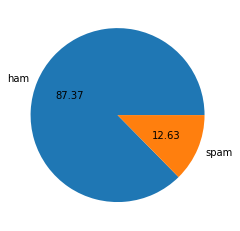

In [ ]:
import matplotlib.pyplot as plt
plt.pie(data['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

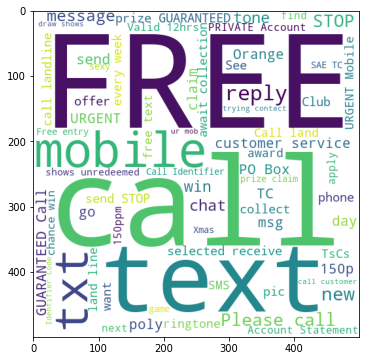

In [295]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(data[data['label'] == 1]['text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

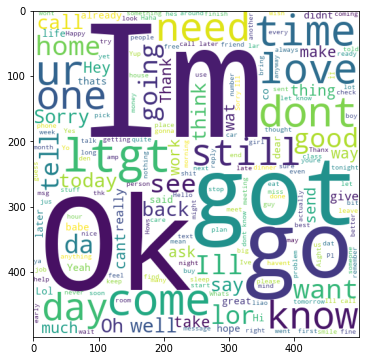

In [296]:
ham_wc = wc.generate(data[data['label'] == 0]['text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

##3. Data Preprocessing

* In this stage we have to remove all the insignificant words in the observation such as **stop words**(eg. etc).In this case there is a library provided by **nltk (natural language tool kit)**.

* **NLTK** is a powerful Python package that provides a set of diverse natural languages algorithms. It is free, opensource, easy to use, large community, and well documented. NLTK consists of the most common algorithms such as tokenizing, part-of-speech tagging, stemming, sentiment analysis, topic segmentation, and named entity recognition. 

* **NLTK** helps the computer to analysis, preprocess, and understand the written text.

* **Tokenization** is the process by which a large quantity of text is divided into smaller parts called tokens. These tokens are very useful for finding patterns and are considered as a base step for stemming.

* **Tokenizers** divide strings into lists of substrings.



In [ ]:
# Import nltk packages and Punkt Tokenizer Models
import nltk
nltk.download("punkt") #punkt is the required package for tokenization
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Punctuation and stop words do not contribute anything to our model, so we have to remove them. Using NLTK library we can easily do it.


we'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query such as “the”, “a”, “an”, “in”, "but", "because" etc.

In [291]:
import nltk
nltk.download('stopwords')

#remove the punctuations and stopwords
import string
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


Now, create a data frame from the processed data before moving to the next step.

In [ ]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

##4. Model Building

we can convert words to vectors using either Count Vectorizer or by using TF-IDF Vectorizer.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

In [ ]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])

vectors.shape


(5572, 9376)

In [ ]:
#features = word_vectors
features = vectors

In [ ]:
#split the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.20, random_state=42)


In [ ]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)

In [ ]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [ ]:
#fit the data into the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [ ]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [ ]:
pred_scores_word_vectors

[('SVC', [0.9784688995215312]),
 ('KN', [0.9246411483253588]),
 ('NB', [0.9844497607655502]),
 ('DT', [0.958732057416268]),
 ('LR', [0.9431818181818182]),
 ('RF', [0.9700956937799043])]

Since the accuracy score of MultinomialNB is best among all so we choose this classifier for our model building.

In [ ]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [ ]:
newtext = ["WINNER!! As a valued network customer you"]
integers = vectorizer.transform(newtext)

In [ ]:
x = mnb.predict(integers)
find(x)


Message is SPAM


We need two model for further used one is vectorizer model for converting out tecxt to vector and other is classification based model.

In [ ]:
#We'll save the model to our local machine:
import pickle
pickle.dump(mnb, open("model_save","wb"))
pickle.dump(vectorizer, open("vectorizer","wb"))


In [ ]:
#Load our model again
model = pickle.load(open("model_save","rb"))
vectorize_model=pickle.load( open("vectorizer","rb"))

In [ ]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [ ]:
newtext = ["WINNER!! As a valued network customer you"]
integers = vectorizer.transform(newtext)
print(integers)

  (0, 9303)	0.5715343876941658
  (0, 9028)	0.4346056771221345
  (0, 8699)	0.4470284391659826
  (0, 5713)	0.39826412693014535
  (0, 2550)	0.35498958981026535


In [ ]:
x = model.predict(integers)
find(x)

Message is SPAM
